In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# A Copy from Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import gc

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/datalake_Quinten_2021-23_hPa-kmh-C-W_50km.zip", index_col=0)
df.index = pd.to_datetime(df.index, unit='ns')
y = df[[column for column in df.columns if column.startswith("Quinten, wind_gusts")]]
y.head()

,"Quinten, wind_gusts_10m:kmh_x","Quinten, wind_gusts_10m:kmh_y"
validdate,,
2021-01-01 00:20:00+00:00,34.194791,0.596872
2021-01-01 00:30:00+00:00,39.194030,-0.684134
2021-01-01 00:40:00+00:00,39.304828,-4.826026
2021-01-01 00:50:00+00:00,36.958823,-3.233478
2021-01-01 01:00:00+00:00,31.922050,-2.232207


In [4]:
df

,"Bad Ragaz, diff_global_rad:W","Bad Ragaz, diff_msl_pressure:hPa","Bad Ragaz, diff_t_2m:C","Bad Ragaz, diff_wind_gusts_10m:kmh_x","Bad Ragaz, diff_wind_gusts_10m:kmh_y","Bad Ragaz, diff_wind_speed_10m:kmh_x","Bad Ragaz, diff_wind_speed_10m:kmh_y","Bad Ragaz, global_rad:W","Bad Ragaz, msl_pressure:hPa","Bad Ragaz, t_2m:C",...,"Wädenswil, wind_speed_10m:kmh_x","Wädenswil, wind_speed_10m:kmh_y","bise, diff_msl_pressure:hPa","bise, msl_pressure:hPa","föhn, diff_msl_pressure:hPa","föhn, msl_pressure:hPa","time, cos_day","time, sin_day","time, cos_year","time, sin_year"
validdate,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:20:00+00:00,0.0,0.10,-0.30,-0.801906,0.408591,0.356403,-0.181596,0.0,1006.8,2.6,...,-5.768227,0.606265,5.000000e-02,-0.2,-1.000000e-01,4.7,0.996141,8.776366e-02,1.0,0.000239
2021-01-01 00:30:00+00:00,0.0,-0.05,0.05,-0.624472,-0.844828,-0.604331,-0.338196,0.0,1006.6,3.0,...,-7.190133,-0.376819,5.000000e-02,-0.3,-3.000000e-01,4.4,0.991325,1.314337e-01,1.0,0.000359
2021-01-01 00:40:00+00:00,0.0,-0.25,0.35,2.372627,-2.033414,0.111114,-0.536431,0.0,1006.3,3.3,...,-8.254532,-0.867586,-1.000000e-01,-0.4,-1.000000e-01,4.5,0.984595,1.748500e-01,1.0,0.000478
2021-01-01 00:50:00+00:00,0.0,-0.30,0.30,0.461712,-6.143016,2.543926,-5.247327,0.0,1006.0,3.6,...,-12.980574,-5.244492,5.000000e-02,-0.2,5.000000e-02,4.5,0.975965,2.179288e-01,1.0,0.000598
2021-01-01 01:00:00+00:00,0.0,-0.10,0.10,-0.486392,-5.376159,1.248055,-4.459618,0.0,1006.1,3.5,...,-12.830494,-6.537463,1.000000e-01,-0.2,5.000000e-02,4.6,0.965450,2.605870e-01,1.0,0.000717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:20:00+00:00,0.0,0.15,-0.20,-4.391061,-0.080989,-1.861638,-0.527691,0.0,1023.6,16.0,...,-3.498479,-1.939238,-5.000000e-02,1.0,5.000000e-02,9.7,0.991325,-1.314337e-01,1.0,-0.000478
2022-12-31 23:30:00+00:00,0.0,0.10,0.10,-2.319035,2.903530,0.471645,0.293617,0.0,1023.7,15.8,...,-1.790139,0.188151,5.000000e-02,1.3,5.684342e-14,9.7,0.996141,-8.776366e-02,1.0,-0.000359
2022-12-31 23:40:00+00:00,0.0,-0.05,0.05,7.228160,2.792588,3.946498,1.872805,0.0,1023.5,16.1,...,-0.528297,0.459241,-5.684342e-14,1.0,2.000000e-01,10.1,0.999035,-4.392422e-02,1.0,-0.000239


In [5]:
X = df.copy()
X.head()

,"Bad Ragaz, diff_global_rad:W","Bad Ragaz, diff_msl_pressure:hPa","Bad Ragaz, diff_t_2m:C","Bad Ragaz, diff_wind_gusts_10m:kmh_x","Bad Ragaz, diff_wind_gusts_10m:kmh_y","Bad Ragaz, diff_wind_speed_10m:kmh_x","Bad Ragaz, diff_wind_speed_10m:kmh_y","Bad Ragaz, global_rad:W","Bad Ragaz, msl_pressure:hPa","Bad Ragaz, t_2m:C",...,"Wädenswil, wind_speed_10m:kmh_x","Wädenswil, wind_speed_10m:kmh_y","bise, diff_msl_pressure:hPa","bise, msl_pressure:hPa","föhn, diff_msl_pressure:hPa","föhn, msl_pressure:hPa","time, cos_day","time, sin_day","time, cos_year","time, sin_year"
validdate,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:20:00+00:00,0.0,0.10,-0.30,-0.801906,0.408591,0.356403,-0.181596,0.0,1006.8,2.6,...,-5.768227,0.606265,0.05,-0.2,-0.10,4.7,0.996141,0.087764,1.0,0.000239
2021-01-01 00:30:00+00:00,0.0,-0.05,0.05,-0.624472,-0.844828,-0.604331,-0.338196,0.0,1006.6,3.0,...,-7.190133,-0.376819,0.05,-0.3,-0.30,4.4,0.991325,0.131434,1.0,0.000359
2021-01-01 00:40:00+00:00,0.0,-0.25,0.35,2.372627,-2.033414,0.111114,-0.536431,0.0,1006.3,3.3,...,-8.254532,-0.867586,-0.10,-0.4,-0.10,4.5,0.984595,0.174850,1.0,0.000478
2021-01-01 00:50:00+00:00,0.0,-0.30,0.30,0.461712,-6.143016,2.543926,-5.247327,0.0,1006.0,3.6,...,-12.980574,-5.244492,0.05,-0.2,0.05,4.5,0.975965,0.217929,1.0,0.000598
2021-01-01 01:00:00+00:00,0.0,-0.10,0.10,-0.486392,-5.376159,1.248055,-4.459618,0.0,1006.1,3.5,...,-12.830494,-6.537463,0.10,-0.2,0.05,4.6,0.965450,0.260587,1.0,0.000717


# Split Data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [10]:
train = 0.6
val = 0.15
test = 0.25
n = df.shape[0]

## Standard Transform

In [11]:
df["Quinten, wind_speed_10m:kmh_x"].head()

validdate
2021-01-01 00:20:00+00:00    19.097091
2021-01-01 00:30:00+00:00    19.097091
2021-01-01 00:40:00+00:00    22.133779
2021-01-01 00:50:00+00:00    17.931505
2021-01-01 01:00:00+00:00    17.257858
Name: Quinten, wind_speed_10m:kmh_x, dtype: float64

In [12]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, PowerTransformer, RobustScaler
from sklearn.pipeline import make_pipeline

In [ ]:
transformers  = {} #to inversetransform with Scaler

X = df.copy()
for column in tqdm(X.columns):
    if any([x in column for x in [" t_", " msl_"]]):
        scaler = StandardScaler()
    elif any([x in column for x in [" wind_gusts", " global_"]]):
        scaler = PowerTransformer()
    elif any([x in column for x in ["time,"]]):
        scaler = StandardScaler()
    else:
        print(column, "will be ignored")
        X.drop(columns=column, inplace=True)
        continue
    scaler.fit(X.iloc[0:int(n*(train+val)),:][column].values.reshape(-1,1)) #train only on train & validation
    X[column]       = scaler.transform(X[column].values.reshape(-1,1))
    transformers[column]  = scaler

In [15]:
label_columns = [column for column in X.columns if "Quinten, wind" in column]
label_columns

['Quinten, wind_gusts_10m:kmh_x', 'Quinten, wind_gusts_10m:kmh_y']

In [16]:
train_df =  X[0:int(n*train)]
val_df =    X[int(n*train):int(n*(train+val))]
test_df =   X[int(n*(train+val)):]

column_indices = {name: i for i, name in enumerate(X.columns)}
num_features = X.shape[1]

In [17]:
num_features

92

In [18]:
my_label = label_columns[1]
my_label

'Quinten, wind_gusts_10m:kmh_y'

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [20]:
w1 = WindowGenerator(input_width=24*6, label_width=1, shift=10,
                     label_columns=label_columns)
w1

Total window size: 154
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label indices: [153]
Label column name(s): ['Quinten, wind_gusts_10m:kmh_x', 'Quinten, wind_gusts_10m:kmh_y']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [21]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [22]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 154, 92)
Inputs shape: (3, 144, 92)
Labels shape: (3, 1, 2)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [23]:
w1.example = example_inputs, example_labels

In [24]:
import matplotlib.cm as cm

In [75]:
def plot(self, model=None, plot_col=[my_label], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  i=-1
  for plot_col in plot_col:
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    colors = cm.Set1(np.linspace(0, 1, len(plot_col)))
    for n in range(max_n):
        i += 1
        plt.subplot(max_n, 1, n+1)
        plt.ylabel("value")
        plt.title(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10, color=colors[i])

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', s=64, color=colors[i])
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    s=64, color=colors[i])

        if n == 0:
            plt.legend()

        plt.xlabel('Step')
        plt.grid(True)
    plt.tight_layout()
WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

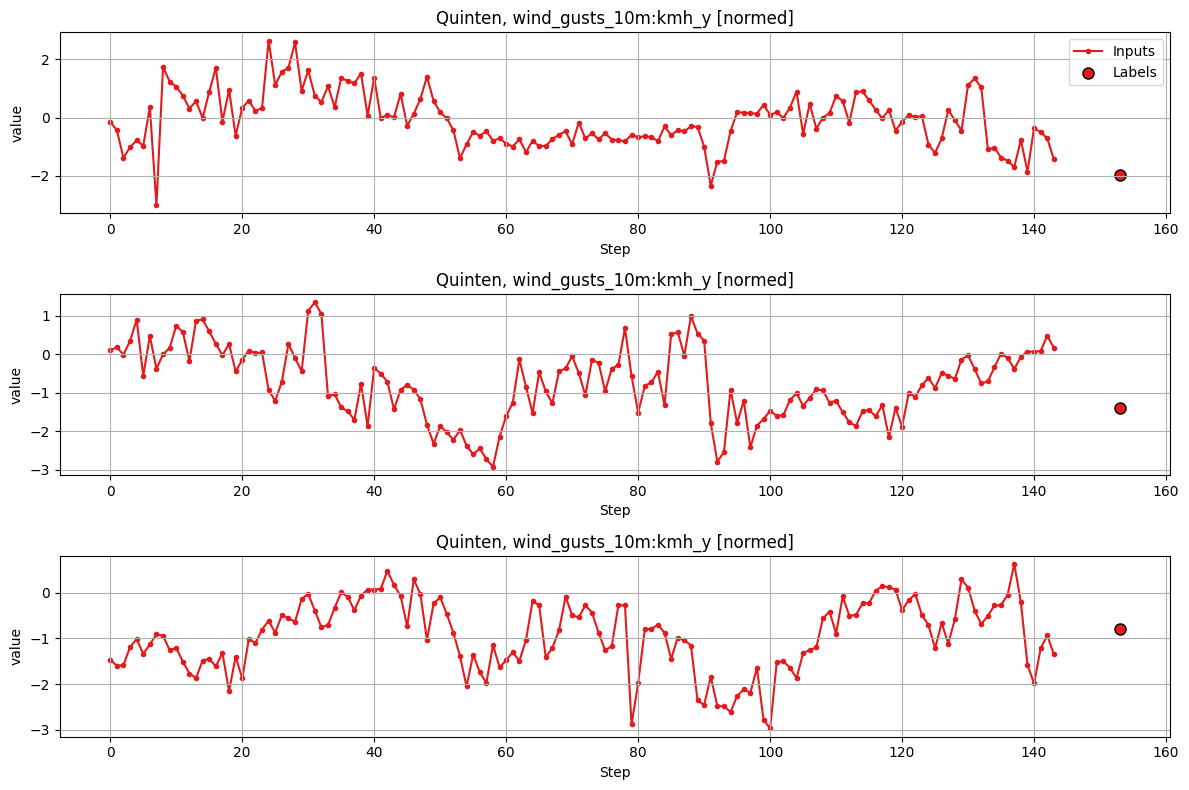

In [26]:
w1.plot()

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [27]:
BATCH_SIZE=6*24*2

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=BATCH_SIZE,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 144, 92), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (288, 144, 92)
Labels shape (batch, time, features): (288, 1, 2)


## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

In [47]:
label_columns

['Quinten, wind_gusts_10m:kmh_x', 'Quinten, wind_gusts_10m:kmh_y']

In [110]:
my_label = label_columns[1]
my_label

'Quinten, wind_gusts_10m:kmh_y'

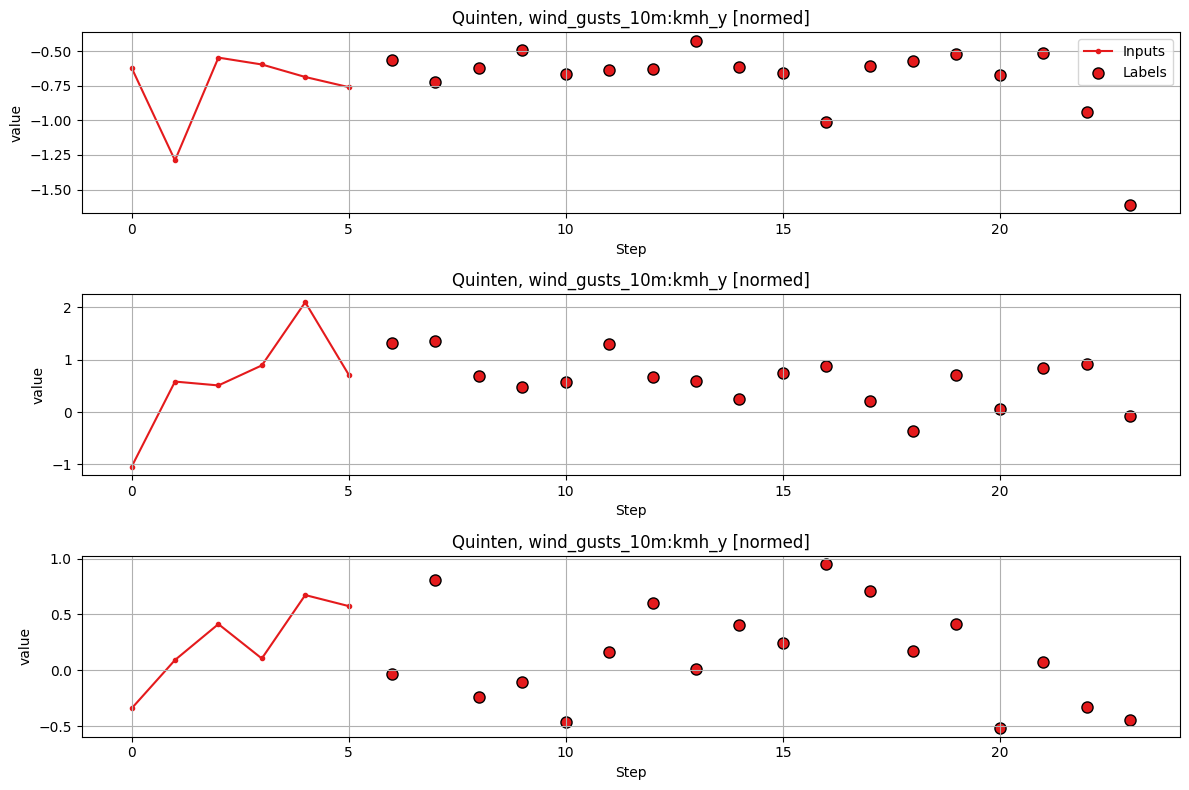

In [111]:
OUT_STEPS = 18
INPUT_WIDTH = 6

multi_window_all = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               )

multi_window_all.plot(plot_col=[my_label])

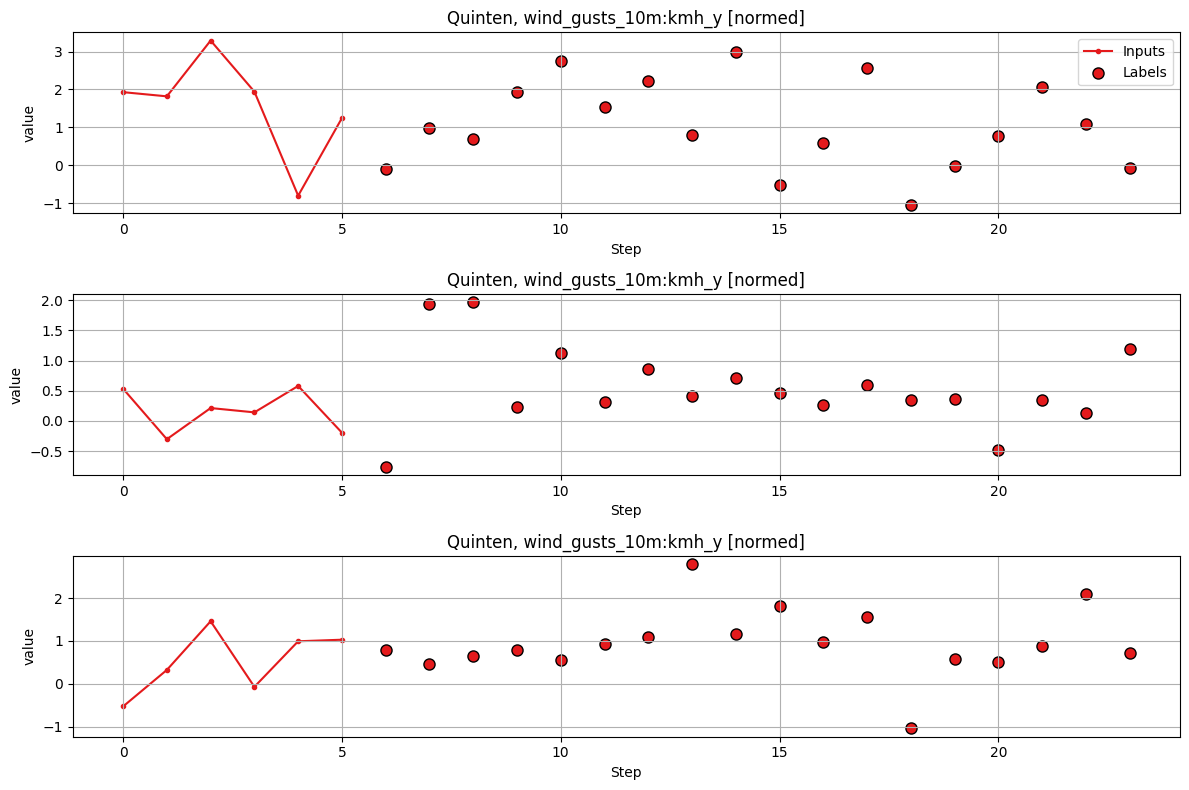

In [112]:
multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=[my_label]
                               )

multi_window.plot()

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

In [113]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.RootMeanSquaredError(),
                               tf.keras.metrics.MeanAbsoluteError()])


In [114]:
multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window_all.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window_all.test, verbose=0)

55/55 [==============================] - 1s 20ms/step - loss: 0.3832 - root_mean_squared_error: 0.6190 - mean_absolute_error: 0.3510


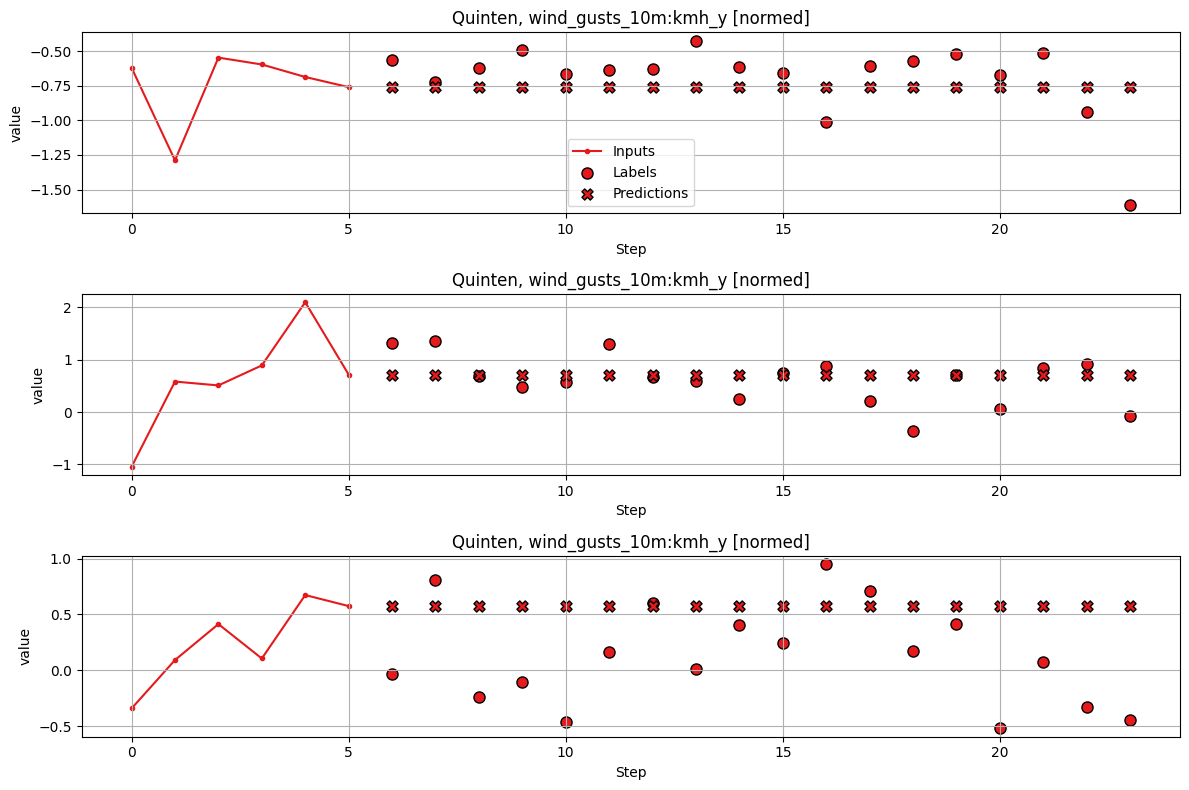

In [115]:
multi_window_all.plot(last_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

In [116]:
from pandas.core.arrays.base import mode
MAX_EPOCHS = 20

def compile_and_fit(model, window):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=3,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(),
                           tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [117]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [118]:
history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 9s 38ms/step - loss: 0.7239 - root_mean_squared_error: 0.8508 - mean_absolute_error: 0.5927 - val_loss: 0.6709 - val_root_mean_squared_error: 0.8191 - val_mean_absolute_error: 0.5500
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.6753 - root_mean_squared_error: 0.8218 - mean_absolute_error: 0.5631 - val_loss: 0.6592 - val_root_mean_squared_error: 0.8119 - val_mean_absolute_error: 0.5404
Epoch 3/20
219/219 [==============================] - 8s 37ms/step - loss: 0.6671 - root_mean_squared_error: 0.8167 - mean_absolute_error: 0.5573 - val_loss: 0.6553 - val_root_mean_squared_error: 0.8095 - val_mean_absolute_error: 0.5378
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.6647 - root_mean_squared_error: 0.8153 - mean_absolute_error: 0.5554 - val_loss: 0.6582 - val_root_mean_squared_error: 0.8113 - val_mean_absolute_error: 0.5384
Epoch 5/20
219/219 [==============================] 

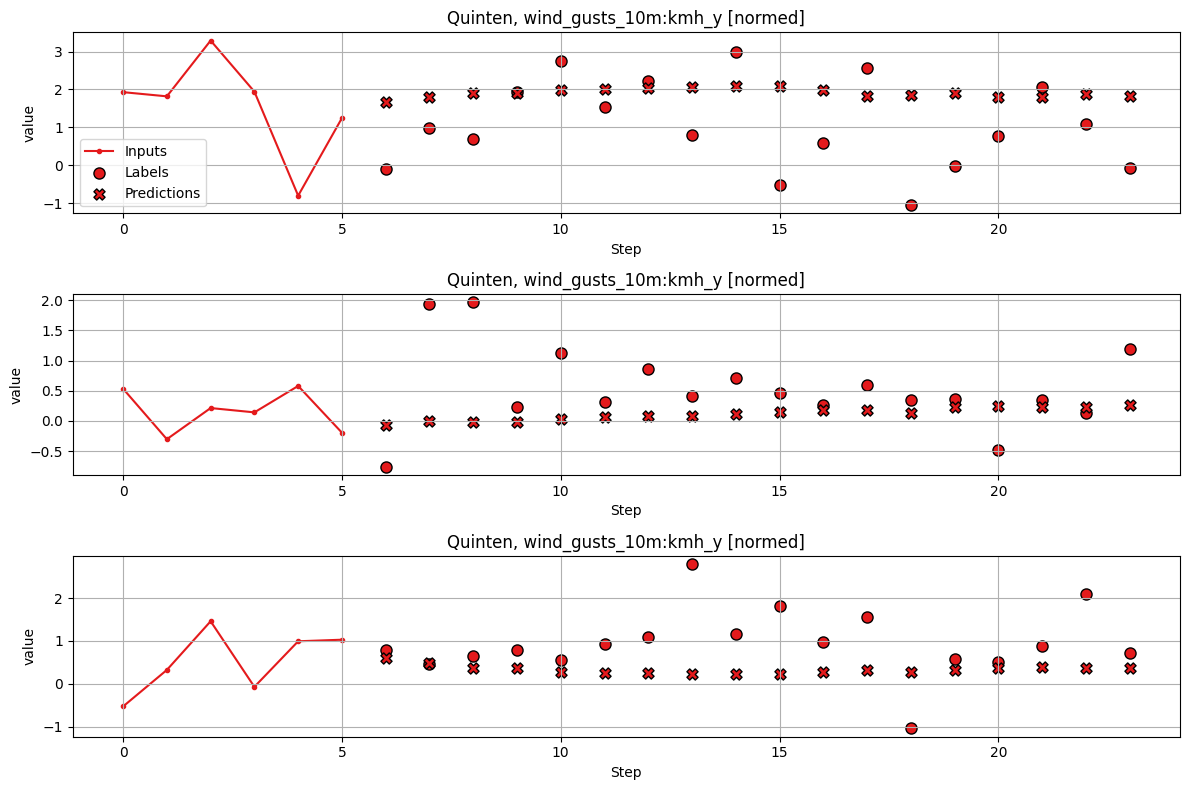

In [119]:
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

In [120]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 12s 51ms/step - loss: 0.6563 - root_mean_squared_error: 0.8101 - mean_absolute_error: 0.5505 - val_loss: 0.6274 - val_root_mean_squared_error: 0.7921 - val_mean_absolute_error: 0.5230
Epoch 2/20
219/219 [==============================] - 11s 50ms/step - loss: 0.6121 - root_mean_squared_error: 0.7824 - mean_absolute_error: 0.5250 - val_loss: 0.6305 - val_root_mean_squared_error: 0.7940 - val_mean_absolute_error: 0.5228
Epoch 3/20
219/219 [==============================] - 11s 49ms/step - loss: 0.5977 - root_mean_squared_error: 0.7731 - mean_absolute_error: 0.5188 - val_loss: 0.6289 - val_root_mean_squared_error: 0.7930 - val_mean_absolute_error: 0.5231
Epoch 4/20
55/55 [==============================] - 2s 33ms/step - loss: 0.6275 - root_mean_squared_error: 0.7921 - mean_absolute_error: 0.5208


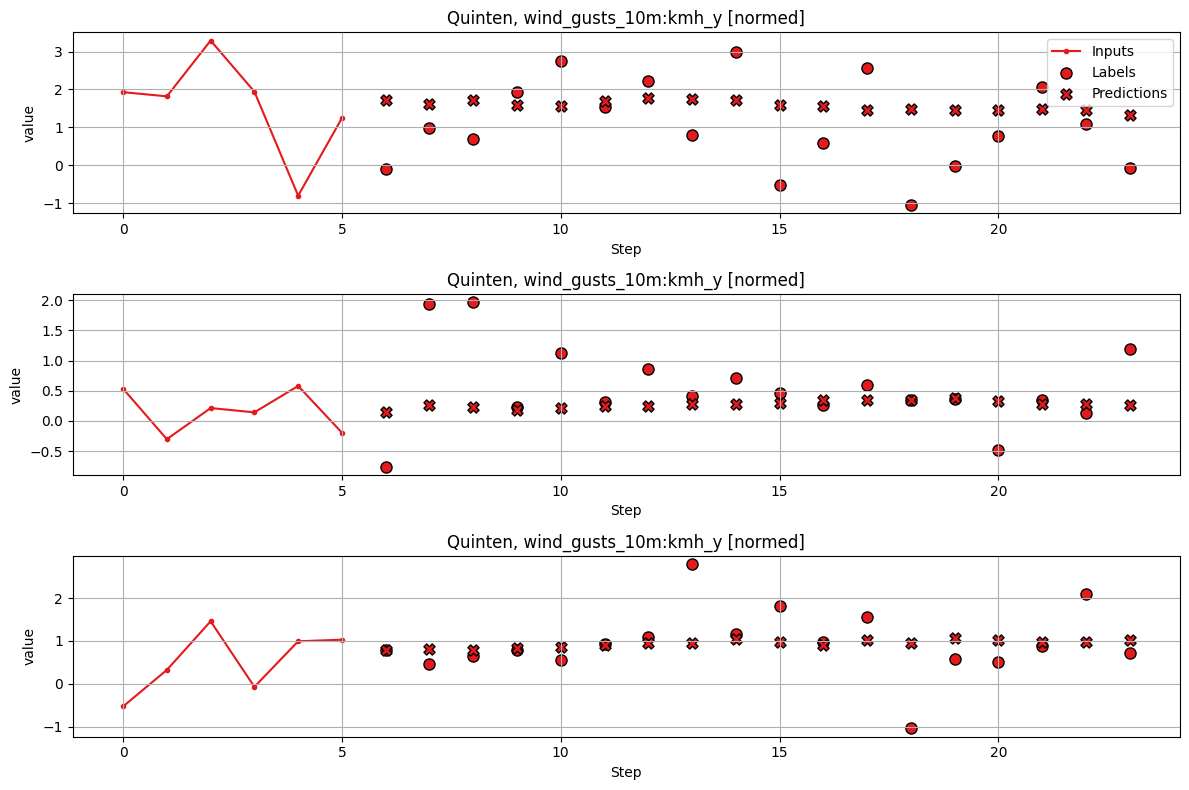

In [121]:
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

In [122]:
CONV_WIDTH = 6
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 10s 41ms/step - loss: 0.6524 - root_mean_squared_error: 0.8077 - mean_absolute_error: 0.5483 - val_loss: 0.6388 - val_root_mean_squared_error: 0.7993 - val_mean_absolute_error: 0.5325
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.6060 - root_mean_squared_error: 0.7784 - mean_absolute_error: 0.5223 - val_loss: 0.6222 - val_root_mean_squared_error: 0.7888 - val_mean_absolute_error: 0.5191
Epoch 3/20
219/219 [==============================] - 9s 39ms/step - loss: 0.5881 - root_mean_squared_error: 0.7669 - mean_absolute_error: 0.5146 - val_loss: 0.6373 - val_root_mean_squared_error: 0.7983 - val_mean_absolute_error: 0.5290
Epoch 4/20
219/219 [==============================] - 9s 40ms/step - loss: 0.5741 - root_mean_squared_error: 0.7577 - mean_absolute_error: 0.5094 - val_loss: 0.6454 - val_root_mean_squared_error: 0.8033 - val_mean_absolute_error: 0.5348
Epoch 5/20
55/55 [==============================] -

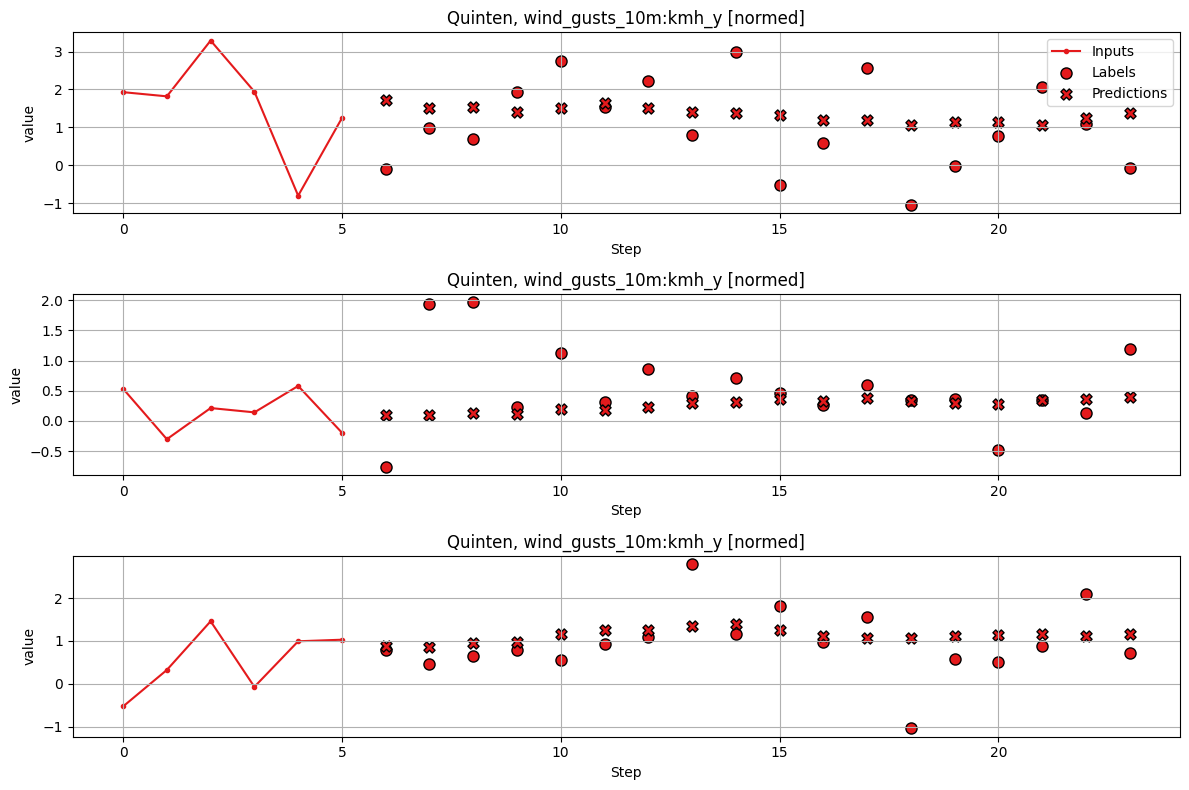

In [123]:
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


In [124]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 11s 39ms/step - loss: 0.7166 - root_mean_squared_error: 0.8465 - mean_absolute_error: 0.5837 - val_loss: 0.6531 - val_root_mean_squared_error: 0.8082 - val_mean_absolute_error: 0.5351
Epoch 2/20
219/219 [==============================] - 9s 41ms/step - loss: 0.6127 - root_mean_squared_error: 0.7828 - mean_absolute_error: 0.5254 - val_loss: 0.6308 - val_root_mean_squared_error: 0.7942 - val_mean_absolute_error: 0.5204
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.5835 - root_mean_squared_error: 0.7639 - mean_absolute_error: 0.5100 - val_loss: 0.6275 - val_root_mean_squared_error: 0.7922 - val_mean_absolute_error: 0.5153
Epoch 4/20
219/219 [==============================] - 9s 41ms/step - loss: 0.5646 - root_mean_squared_error: 0.7514 - mean_absolute_error: 0.5007 - val_loss: 0.6294 - val_root_mean_squared_error: 0.7934 - val_mean_absolute_error: 0.5157
Epoch 5/20
219/219 [==============================]

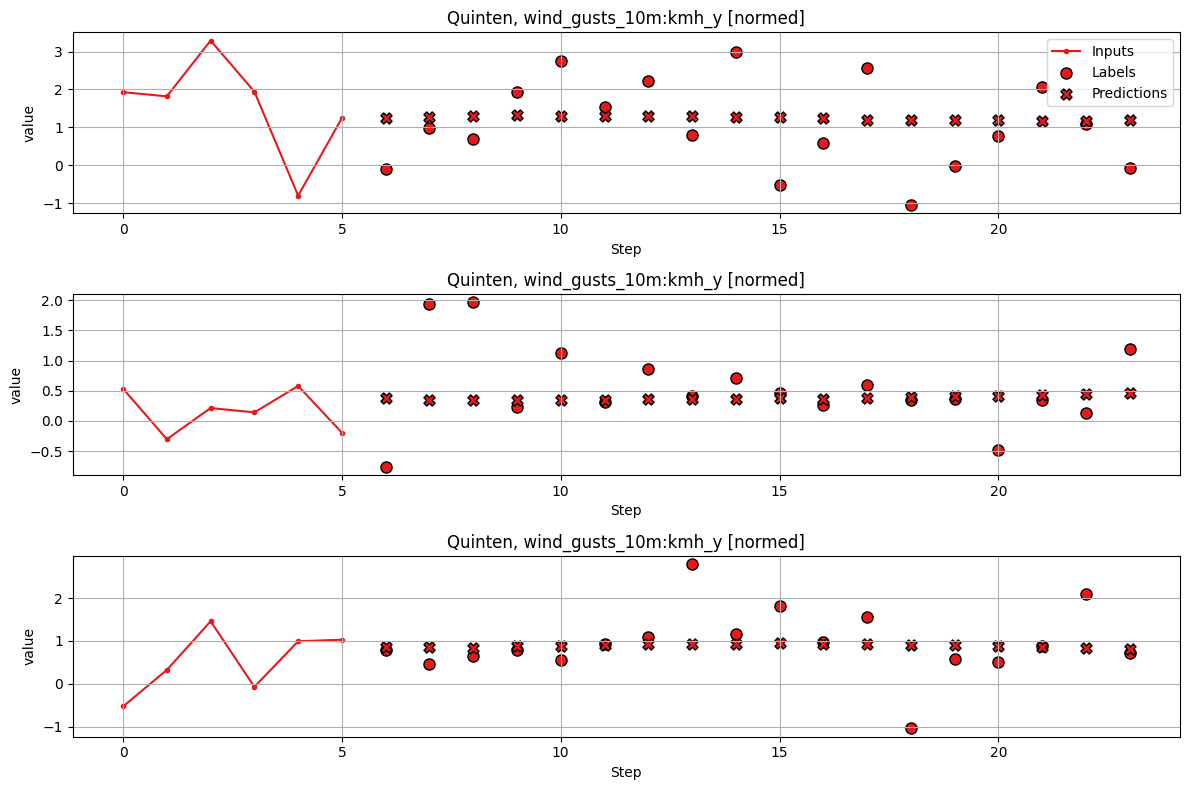

In [125]:
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [126]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [127]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [128]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [129]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([288, 92])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [130]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [131]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (288, 18, 92)


Now, train the model:

In [132]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 15s 56ms/step - loss: 0.7352 - root_mean_squared_error: 0.8574 - mean_absolute_error: 0.5922 - val_loss: 0.6766 - val_root_mean_squared_error: 0.8226 - val_mean_absolute_error: 0.5493
Epoch 2/20
219/219 [==============================] - 12s 54ms/step - loss: 0.6341 - root_mean_squared_error: 0.7963 - mean_absolute_error: 0.5366 - val_loss: 0.6674 - val_root_mean_squared_error: 0.8169 - val_mean_absolute_error: 0.5427
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.6083 - root_mean_squared_error: 0.7800 - mean_absolute_error: 0.5238 - val_loss: 0.6588 - val_root_mean_squared_error: 0.8117 - val_mean_absolute_error: 0.5311
Epoch 4/20
219/219 [==============================] - 12s 55ms/step - loss: 0.5899 - root_mean_squared_error: 0.7681 - mean_absolute_error: 0.5147 - val_loss: 0.6532 - val_root_mean_squared_error: 0.8082 - val_mean_absolute_error: 0.5294
Epoch 5/20
219/219 [============================

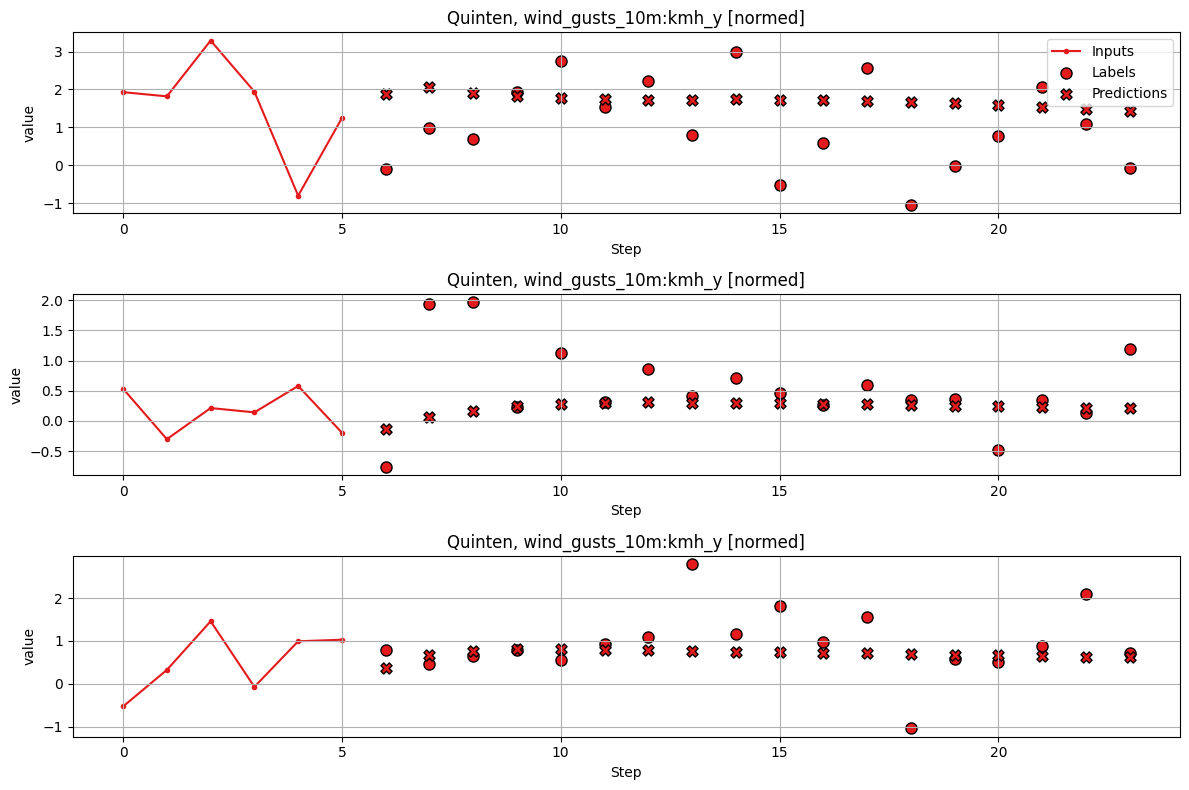

In [133]:
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

In [134]:
for element in [multi_val_performance, multi_performance]:
    for name, value in element.items():
        element[name] = list(transformers[my_label].inverse_transform(np.array(value).reshape(-1, 1)).reshape(1,-1)[0])

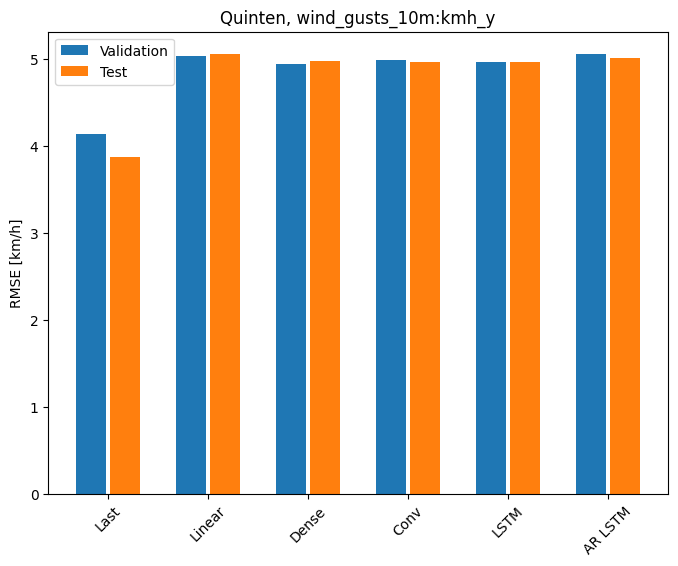

In [135]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'root_mean_squared_error'
metric_index = multi_lstm_model.metrics_names.index('root_mean_squared_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.title(my_label)
plt.ylabel('RMSE [km/h]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps.

In [136]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 3.8737
Linear  : 5.0606
Dense   : 4.9811
Conv    : 4.9622
LSTM    : 4.9680
AR LSTM : 5.0142


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
